# Processing the data

## Libraries

In [ ]:
import time
import os
from sys import argv, path
import sys
import datetime
import json
from torch import Tensor
import importlib
from tqdm import tqdm

In [ ]:
import numpy as np
import pandas as pd
import os
import pickle
import torch
import torch.nn.functional as F

from lips import get_root_path
from lips.dataset.scaler.standard_scaler import StandardScaler
from lips.benchmark.airfransBenchmark import AirfRANSBenchmark
from lips.dataset.airfransDataSet import download_data

In [ ]:
import datetime as dt
from torch_geometric.loader import DataLoader as DLG
from torch_geometric.data import Data
from lips.dataset.scaler.standard_scaler_iterative import StandardScalerIterative
from torch.utils.data import DataLoader
import random

## Importing the data

In [17]:
# indicate required paths
LIPS_PATH = get_root_path()
DIRECTORY_NAME = '../src/Dataset'
BENCHMARK_NAME = "Case1"
LOG_PATH = LIPS_PATH + "lips_logs.log"

In [18]:
root_dir = r"C:/Users/antho/Desktop/ml4physim/src/"
default_input_dir = root_dir + "Dataset"
default_output_dir = root_dir + "mixing_attention/sample_result_submission"
default_program_dir = root_dir + "mixing_attention"
default_submission_dir = root_dir + "mixing_attention"
input_dir = default_input_dir
output_dir = default_output_dir
program_dir= default_program_dir
submission_dir= default_submission_dir
DIRECTORY_NAME = root_dir + 'Dataset'
BENCHMARK_NAME = "Case1"
LOG_PATH = root_dir + "lips_logs.log"
BENCH_CONFIG_PATH = os.path.join(root_dir, "LIPS","configurations","airfoil","benchmarks","confAirfoil.ini") #Configuration file related to the benchmark
SIM_CONFIG_PATH = os.path.join(submission_dir,"config.ini")
SAVE_PATH = os.path.join(output_dir,"AirfRANSModel")

In [19]:
# Load the required benchmark datasets, if it is not pickled, pickle it for future use
try:
    with open(root_dir + "benchmark.pkl", 'rb') as f:
        benchmark = pickle.load(f)
except:
    benchmark = AirfRANSBenchmark(benchmark_path=DIRECTORY_NAME,
                                  config_path=BENCH_CONFIG_PATH,
                                  benchmark_name=BENCHMARK_NAME,
                                  log_path=LOG_PATH)
    benchmark.load(path=DIRECTORY_NAME)
    with open(root_dir + "benchmark.pkl", 'wb') as f:
        pickle.dump(benchmark, f)

Creating the simulator

In [20]:
class ModelApiError(Exception):
    """Model api error"""

    def __init__(self, msg=""):
        self.msg = msg
        print(msg)

def import_parameters(submission_dir):
    ## import parameters.json as a dictionary
    path_submission_parameters = os.path.join(submission_dir, 'parameters.json')
    if not os.path.exists(path_submission_parameters):
        raise ModelApiError("Missing parameters.json file")
        exit_program()
    with open(os.path.join(submission_dir, 'parameters.json')) as json_file:
        parameters = json.load(json_file)
    return parameters

run_parameters = import_parameters(default_submission_dir)

simulator_parameters = run_parameters["simulator_config"]
print("Loading custom simulator " + simulator_parameters["model"])
print("Loading custom simulator " + simulator_parameters["simulator_file"])
# Import user-provided simulator code
simulator_module = importlib.import_module(simulator_parameters["simulator_file"])
simulator_class = getattr(simulator_module, simulator_parameters["model"])

simulator = simulator_class(benchmark=benchmark,
                        **run_parameters["simulator_extra_parameters"]
                        )

Loading custom simulator AugmentedSimulator
Loading custom simulator my_custom_batch_attention
Using GPU


In [21]:
train_dataset = simulator.process_dataset(benchmark.train_dataset, training=True)
data0 = train_dataset[26]
data0

Normalize train data
Transform done


Data(x=[181379, 7], y=[181379, 4], pos=[181379, 2], surf=[181379], skeleton_features=[1000, 7], skeleton_pos=[1000, 2])

In [25]:
print("dataset list:")
train_dataset

dataset list:


[Data(x=[170180, 7], y=[170180, 4], pos=[170180, 2], surf=[170180], skeleton_features=[1000, 7], skeleton_pos=[1000, 2]),
 Data(x=[179653, 7], y=[179653, 4], pos=[179653, 2], surf=[179653], skeleton_features=[1000, 7], skeleton_pos=[1000, 2]),
 Data(x=[184381, 7], y=[184381, 4], pos=[184381, 2], surf=[184381], skeleton_features=[1000, 7], skeleton_pos=[1000, 2]),
 Data(x=[177944, 7], y=[177944, 4], pos=[177944, 2], surf=[177944], skeleton_features=[1000, 7], skeleton_pos=[1000, 2]),
 Data(x=[178145, 7], y=[178145, 4], pos=[178145, 2], surf=[178145], skeleton_features=[1000, 7], skeleton_pos=[1000, 2]),
 Data(x=[178100, 7], y=[178100, 4], pos=[178100, 2], surf=[178100], skeleton_features=[1000, 7], skeleton_pos=[1000, 2]),
 Data(x=[174285, 7], y=[174285, 4], pos=[174285, 2], surf=[174285], skeleton_features=[1000, 7], skeleton_pos=[1000, 2]),
 Data(x=[174181, 7], y=[174181, 4], pos=[174181, 2], surf=[174181], skeleton_features=[1000, 7], skeleton_pos=[1000, 2]),
 Data(x=[178475, 7], y=[

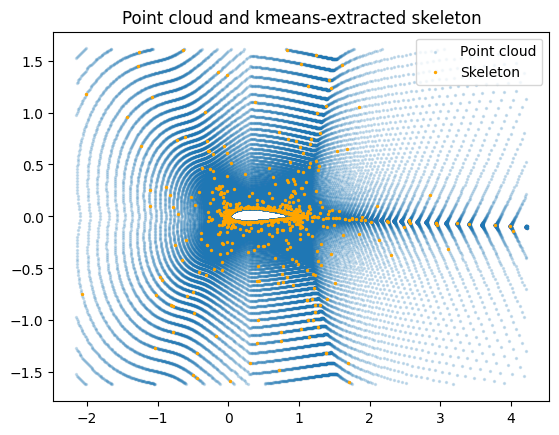

In [40]:
# plotting the point cloud and the extracted skeleton
pos = data0.pos
skeleton_pos = data0.skeleton_pos

#plot
import matplotlib.pyplot as plt

#small dots in scatter plot
plt.scatter(pos[:,0], pos[:,1], alpha=0.2, s=2)
plt.scatter(skeleton_pos[:,0], skeleton_pos[:,1], color='orange', s=2)
plt.legend(['Point cloud', 'Skeleton'])
plt.title('Point cloud and kmeans-extracted skeleton')
plt.show()


## K-means clustering


Because each simulation has too many points, using the global attention mechanism on each point of the simulation results in needing more than 100GB of memory.

This is not feasible.
One way of dealing with it is to use a different formula for the attention layer, which makes use of a second set of "important" points.
We can for instance use the K-means algorithm to create such a set, which would summarize the global information of the dataset.

Uniform at random initialization and k-means-plus-plus initialisation have been compared

In [ ]:
from my_attention_simulator import skeleton_sampling

### Using uniform initialisation

In [47]:
t = dt.datetime.now()

clustroid_idx_list = []
for data in tqdm(train_dataset):
    data_pos = data.clone().pos
    clustroid_idx = skeleton_sampling(data_pos, k=1000, method="uniform", n_iter=1000)
    clustroid_idx_list.append(clustroid_idx)
    del(data_pos)

print("Time taken: ", dt.datetime.now() - t)

100%|██████████| 103/103 [00:00<00:00, 229.74it/s]

Time taken:  0:00:00.450341


Cool, the algorithm runs really fast!

### Using kmeans-plus-plus initialisation

In [ ]:
# Only run if you are willing to wait 3hrs+
t = dt.datetime.now()

clustroid_idx_list = []
for data in tqdm(train_dataset):
    data_pos = data.clone().pos
    clustroid_idx = skeleton_sampling(data_pos, k=1000, method="kmeans", n_iter=100)
    clustroid_idx_list.append(clustroid_idx)
    del(data_pos)

print("Time taken: ", dt.datetime.now() - t)

Because of the size of the used tensors - $\Theta$($10^6$) points - the complexity of computing the probabilities at each step is way too long...

## Iterating through the dataset

Computations remain memory-heavy. We still need smaller batches to iterate on. In the following, we explore how we can create a custom batching of the data.

Because we are using an attention mechanism, having batches of constant size is important. Because the `batch_size` doesn't necessarily divide the size of a simulation point-clound, doing a classic batching would result in having a last batch of smaller size. We can handle this by repeating other point-datas in this last batch, and after inference, only consider the first inputs.

In [42]:
def data_batching(X: Tensor, batch_size: int=7):
    n = X.shape[0]
    q,r = X.shape[0]//batch_size, X.shape[0]%batch_size
    split_X = []
    for i in range(X.shape[0]//batch_size):
        split_X.append(X[batch_size*i:batch_size*(i+1),:])
    if r > 0:
        split_X.append(torch.cat([X[q*batch_size:,:], split_X[-1][-(batch_size-r):,:]]))
    return split_X, r

In [45]:
X = torch.arange(23).reshape(-1,1).repeat(1,5)
print("Shape of X:", X.shape)
batch_size = 7
split_X, r = data_batching(X, batch_size)

# check that the size of the splitted slices are correct
for i in range(len(split_X)):
    assert len(split_X[i])==batch_size, f"Error in split_data, for batch {i}"

print(f"penultimate batch :\n {split_X[-2]}\n")
print(f"last batch :\n {split_X[-1]}")

Shape of X: torch.Size([23, 5])
penultimate batch :
 tensor([[14, 14, 14, 14, 14],
        [15, 15, 15, 15, 15],
        [16, 16, 16, 16, 16],
        [17, 17, 17, 17, 17],
        [18, 18, 18, 18, 18],
        [19, 19, 19, 19, 19],
        [20, 20, 20, 20, 20]])

last batch :
 tensor([[21, 21, 21, 21, 21],
        [22, 22, 22, 22, 22],
        [16, 16, 16, 16, 16],
        [17, 17, 17, 17, 17],
        [18, 18, 18, 18, 18],
        [19, 19, 19, 19, 19],
        [20, 20, 20, 20, 20]])


We repeat the last batch's last elements, until the last batch is of full size.

In [ ]:
# testing for different data sizes and batch_size sizes
def test(n=1000, batch_size=7):
    for size in range(batch_size, n):
        X = torch.arange(size).reshape(-1,1).repeat(1,5)

        assert batch_size <= size, "Error in split_data, batch_size should be smaller than the size of the input"

        split_X, r = data_batching(X, batch_size)

        # check that the size of the splitted slices are correct
        for i in range(len(split_X)):
            assert len(split_X[i])==batch_size, f"Error in split_data, for batch {i} of iteration {size}"
        
        # check if all the datapoints are in the split dataset
        assert False not in (torch.cat(split_X).unique()==X.unique()).tolist(), f"Error in split_data, the dataset is not correctly split for iteration {size}"

    print(f"split_data function is working properly for a batch size of {batch_size} on {batch_size} to {n} tensor sizes")
    return 0

test(1000, 5)
test(1000, 7)
test(1000, 13)
test(1000, 6)
test(1000, 2)

___

In [ ]:
train_dataset = simulator.process_dataset(benchmark.train_dataset, training=True)

In [ ]:
train_loss_surf_list = []
train_loss_vol_list = []
loss_surf_var_list = []
loss_vol_var_list = []

hparams = simulator.hparams

pbar_train = tqdm(range(hparams['nb_epochs']), position=0)
epoch_nb = 0

for epoch in pbar_train:
    epoch_nb += 1
    print('Epoch: ', epoch_nb)
    train_dataset_sampled = []
    if hparams['subsampling'] != "None":
        for data in train_dataset:
            data_sampled = data.clone()
            idx = random.sample(range(data_sampled.x.size(0)), hparams['subsampling'])
            idx = torch.tensor(idx)

            data_sampled.pos = data_sampled.pos[idx]
            data_sampled.x = data_sampled.x[idx]
            data_sampled.y = data_sampled.y[idx]
            data_sampled.surf = data_sampled.surf[idx]
            train_dataset_sampled.append(data_sampled)

            X = torch.arange(data_sampled.x.shape[0]).reshape(-1,1)
            batch_indices, r = data_batching(X, batch_size = hparams["batch_size"])
            for batch_id in batch_indices:
                train_dataset_sampled.append(Data(pos = data_sampled.pos[batch_id.squeeze()], \
                                                    x = data_sampled.x[batch_id.squeeze()], \
                                                    y = data_sampled.y[batch_id.squeeze()], \
                                                    surf = data_sampled.surf[batch_id.squeeze()]))
    else:
        for data in train_dataset:
            data_sampled = data.clone()
            X = torch.arange(data_sampled.x.shape[0]).reshape(-1,1)
            batch_indices, r = data_batching(X, batch_size = hparams["batch_size"])
            for batch_id in batch_indices:
                train_dataset_sampled.append(Data(pos = data_sampled.pos[batch_id.squeeze()], \
                                                    x = data_sampled.x[batch_id.squeeze()], \
                                                    y = data_sampled.y[batch_id.squeeze()], \
                                                    surf = data_sampled.surf[batch_id.squeeze()]))
    train_loader = DataLoader(train_dataset_sampled, batch_size = hparams['batch_size'], shuffle = True, drop_last = True)
    del(train_dataset_sampled)

In [ ]:
len(train_loader.dataset)

In [ ]:
simulator.model(train_loader, y=torch.arange(10).reshape(-1,1).repeat(1,7))

## Training

In [ ]:
print("Training simulator")
simulator.train(benchmark.train_dataset, 
                    save_path=None, 
                    **run_parameters["training_config"]
                    )

## Some statistics about the dataset

In [ ]:
# computing mean and standard deviation of the number of meshpoints per simumation
mean    = 0
std     = 0
n = len(train_dataset.dataset)

for i in range(n):
    mean += train_dataset.dataset[i].x.shape[0]
mean /= len(train_dataset.dataset)

for i in range(n):
    std += (train_dataset.dataset[i].x.shape[0] - mean)**2
std = np.sqrt(std/len(train_dataset.dataset))

print(f"Number of datapoint per simulation - mean: {mean}, std: {std}")

IC_plus     = mean + 1.96*std/np.sqrt(n)
IC_minus    = mean - 1.96*std/np.sqrt(n)

print(f"Confidence interval at 95% of the size of the simulations: {IC_minus} - {IC_plus}")

n_sample = 32000
print(f"To have {n_sample} samples per cluster, one needs {mean/n_sample} +/- {1.96*std/(np.sqrt(n)*n_sample)} at the 95% confidence interval")

___

In [ ]:
import torch
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt

training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor()
)

from torch.utils.data import DataLoader

train_dataloader = DataLoader(training_data, batch_size=64, shuffle=True)

___

# K-means clustering

# using a uniform at random initialisation
def centroid_uniform_initialisation(X:Tensor, k: int=100):
    samples = np.random.choice(a=X.shape[0], replace=False, size=k)
    return X[samples,:]

# using the k-means++ initialisation
def kmeans_pp_initialisation(X: torch.Tensor, k: int):
    n_samples = X.shape[0]
    # Step 1: Choose one center uniformly at random from among the data points.
    centroids = X[torch.randint(0, n_samples, (1,))]

    for _ in range(k - 1):
        # Step 2: For each data point x, compute D(x), the distance between x and the nearest center that has already been chosen.
        distances = torch.cdist(X, centroids, p=2)
        min_distances = torch.min(distances, dim=1)[0]

        # Step 3: Choose one new data point at random as a new center, using a weighted probability distribution where a point x is chosen with probability proportional to D(x)^2.
        probabilities = min_distances / torch.sum(min_distances)
        new_centroid_idx = torch.multinomial(probabilities, 1)

        # Add the new centroid to the list of centroids
        centroids = torch.cat([centroids, X[new_centroid_idx]], dim=0)

    return centroids

def k_means(X:Tensor, k: int=6, n_iter: int=200):
    center = X.mean(0)
    centroids = kmeans_pp_initialisation(X,k)
    weights = (1/(((X - center)**2).sum(1) + 1e-15)).reshape(-1,1)
    weights = torch.ones(X.shape[0]).reshape(-1,1)

    for i in range(n_iter):
        # compute the distance of each point to the centroids
        distances = torch.cdist(X, centroids, p=2)

        # define the index associated to each centroid
        cluster_idx = torch.argmin(distances, dim=1)

        # compute the new centroids
        new_centroids = torch.stack([(weights[cluster_idx==i]*X[cluster_idx==i]).mean(0) for i in range(k)])

        # end when we have converged
        if torch.all(centroids == new_centroids):
            break

        centroids = new_centroids
    return cluster_idx, centroids

---

In [ ]:
def cluster_id(X:Tensor, k: int=6, center:Tensor=torch.zeros(2)):
    
    angle = torch.arctan2(X[:,1] - center[0], X[:,0] - center[1]) + torch.pi
    index = k*angle/(2*torch.pi)
    return torch.floor(index).type(torch.int32)


def custom_clustering(X:Tensor, k: int=5, n_iter: int=200, radius: float=0.5):
    indices = torch.arange(X.shape[0])
    center = X.mean(0)

    center_mask = torch.sqrt(((X - center)**2).sum(1)) <= radius
    center_ids = indices[center_mask]
    other_ids = indices[~center_mask]
    center_points = X[center_ids]
    other_points = X[other_ids]

    center_clusters = k_means(center_points, k)
    other_clusters  = k_means(other_points, k) + k

    clusters = torch.zeros(X.shape[0], dtype=torch.int32)
    clusters[center_ids] = center_clusters.int()
    clusters[other_ids] = other_clusters.int()

    return clusters

In [ ]:
#scatter plot of X, with alphas to show the clusters and color the cluster using idx
import matplotlib.pyplot as plt

def plot_clusters(X, idx):
    plt.scatter(X[:,0], X[:,1], c=idx, alpha=1)

radius = 1.0
data = processed_data.dataset[0]
X = data.x[:,0:2]
cluster_idx = custom_clustering(X, 6, radius=radius)
center = X.mean(0)

plot_clusters(X, cluster_idx)
# add an x marker at the center of the figure
plt.scatter(center[0], center[1], c='r', marker='x')
plt.scatter(0,0, c='r', marker='o')

#plot circle of radius 0.5
circle = plt.Circle((center[0], center[1]), radius, color='r', fill=False)
plt.gca().add_artist(circle)

plt.xlim(-1,1)
plt.ylim(-1,1)
plt.show()
pd.Series(cluster_idx).value_counts()

In [ ]:
index = 18
X = processed_data.dataset[index].pos
n = int(X.shape[0]/50)

z = torch.arange(X.shape[0])
z = z//n
plot_clusters(X, z)

In [ ]:
distance_from_center = torch.sqrt(((X - center)**2).sum(1, keepdim=False))

sorted_distance = torch.sort(distance_from_center)[0]
plt.figure()
plt.plot(sorted_distance, )
plt.vlines(x = 0.7, ymin=0, ymax=1, color='r', linestyle='--')
plt.title("CDF of the distance from the center") 

In [ ]:
buffer = []
for data in processed_data.dataset:
    X = data.pos
    center = X.mean(0)
    distance_from_center = torch.sqrt(((X - center)**2).sum(1, keepdim=False))
    sorted_distance = torch.sort(distance_from_center)[0]
    mask = (torch.linspace(0,1,sorted_distance.shape[0]) <= 0.5)
    sorted_distance[mask][-1]
    buffer.append(sorted_distance[mask][-1].item())

In [ ]:
np.mean(buffer)

In [ ]:
np.std(buffer)

In [ ]:
center = X.mean(0)
plt.plot(X[data.surf,0], X[data.surf,1], 'ro')
plt.plot(center[0], center[1], c='b', marker='x')

In [ ]:
pd.Series(cluster_idx).value_counts()

In [ ]:
X[data]

In [ ]:
def cluster_id(X:Tensor, k: int=6, center:Tensor=torch.zeros(2)):
    
    angle = torch.arctan2(X[:,1] - center[0], X[:,0] - center[1]) + torch.pi
    index = k*angle/(2*torch.pi)
    return torch.floor(index).type(torch.int32)

data = processed_data.dataset[0]
X = data.pos
center = X[data.surf].mean(0)
cluster_ids = cluster_id(X, k=10, center=center)
plot_clusters(X, cluster_ids)
pd.Series(cluster_ids).value_counts()

In [ ]:
for cluster_id in cluster_idx.unique():
    initial_batch_ids = initial_ids[cluster_idx == cluster_id]
    batch_data = data[initial_batch_ids, :]
    batch_target = target[initial_batch_ids, :]
    

In [ ]:
initial_ids

The points are concentrated arround the airfoil, so we don't have very balanced clusters...

In [ ]:
import seaborn as sns

#zoom around the airfoil
sns.jointplot(x=X[:,0], y=X[:,1], kind="hex", xlim=(-0.5,0.5), ylim=(-0.5,0.5))

We need to cluster our point-cloud and keep small sized clusters, without having too many...

# Trying torch-cluster?